In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, OptimizerType, SamplingMethod, plot_loss_df, set_seeds

## Wave Equation

$$ u_{tt} = 4 u_{xx}$$

$$u(x,0)=x^3, u_t(x,0)=\sin x$$

The solution is $u(x,t) = x^3 + 8xt^2 + \frac{1}{2} \sin x \sin 2t$

=============================Summary of Model wave==============================
Config: {
 "batch_size": 20,
 "num_epochs": 10000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{}

================================State Variables=================================
x: [-1, 1]
t: [0, 1]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: u
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (linear_3): Line

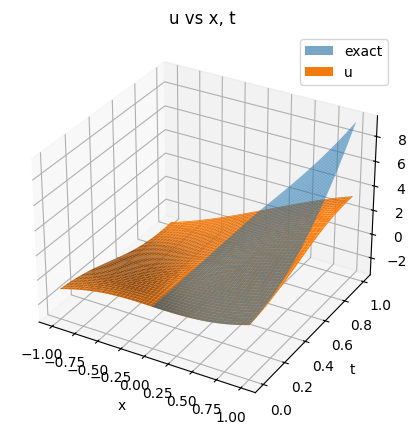

In [2]:
set_seeds(0)
pde = PDEModel("wave", {"optimizer_type": OptimizerType.Adam, "num_epochs": 10000, "sampling_method": SamplingMethod.FixedGrid, "batch_size": 20})
pde.set_state(["x", "t"], {"x": [-1, 1], "t": [0, 1]})
pde.add_endog("u")
pde.add_endog_equation("u_tt = 4 * u_xx", label="pde")

zero_ts = torch.zeros((100, 2))
zero_ts[:, 0] = torch.linspace(-1, 1, 100)
cubed = zero_ts[:, 0:1] ** 3
sin_x = torch.sin(zero_ts[:, 0:1])

pde.add_endog_condition("u", 
                        "u(SV)", {"SV": zero_ts},
                        Comparator.EQ,
                        "y", {"y": cubed},
                        label="ic1")
pde.add_endog_condition("u", 
                        "u_t(SV)", {"SV": zero_ts},
                        Comparator.EQ,
                        "y", {"y": sin_x},
                        label="ic2")
print(pde)
if not os.path.exists("./models/wave1/model.pt"):
    pde.train_model("./models/wave1", "model.pt", True)
    pde.load_model(torch.load("./models/wave1/model_best.pt"))
    pde.eval_model(True)
else:
    pde.load_model(torch.load("./models/wave1/model_best.pt"))
    pde.eval_model(True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
x_np = np.linspace(0, 1, 100)
t_np = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_np, t_np)
exact_Z = X**3 + 8 * X * T**2 + 0.5 * np.sin(X) * np.sin(2*T)
ax.plot_surface(X, T, exact_Z, label="exact", alpha=0.6)
pde.endog_vars["u"].plot("u", {"x": [-1., 1.], "y": [0, 1.]}, ax=ax)
plt.subplots_adjust()
plt.show()

## Wave Equation with piecewise IC

$$ u_{tt} = u_{xx}$$

$$
u(x,0)=\begin{cases}
x+1, -1\leq x\leq 0\\
-x + 1, 0\leq x \leq 1\\
0, |x| > 1
\end{cases}, 
u_t(x,0)= 0
$$

=============================Summary of Model wave==============================
Config: {
 "batch_size": 20,
 "num_epochs": 10000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{}

================================State Variables=================================
x: [-2, 2]
t: [0, 1]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: u
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (linear_3): Line

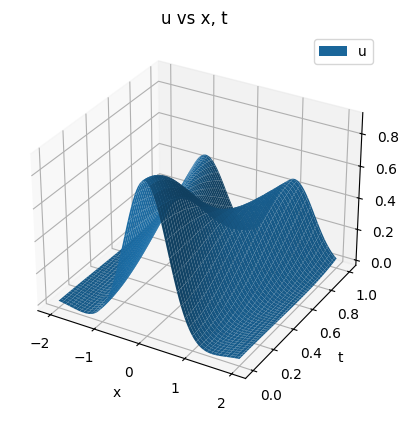

In [3]:
set_seeds(0)
pde = PDEModel("wave", {"optimizer_type": OptimizerType.Adam, "num_epochs": 10000, "sampling_method": SamplingMethod.FixedGrid, "batch_size": 20})
pde.set_state(["x", "t"], {"x": [-2, 2], "t": [0, 1]})
pde.add_endog("u")
pde.add_endog_equation("u_tt = u_xx", label="pde")

zero_ts = torch.zeros((100, 2))
zero_ts[:, 0] = torch.linspace(-2, 2, 100)
piecewise_ic = torch.where((zero_ts[:, 0:1] >= -1) & (zero_ts[:, 0:1] <= 0), zero_ts[:, 0:1] + 1, 
                           torch.where((zero_ts[:, 0:1] >= 0) & (zero_ts[:, 0:1] <= 1), - zero_ts[:, 0:1] + 1, 0))

pde.add_endog_condition("u", 
                        "u(SV)", {"SV": zero_ts},
                        Comparator.EQ,
                        "y", {"y": piecewise_ic},
                        label="ic1")
pde.add_endog_condition("u", 
                        "u_t(SV)", {"SV": zero_ts},
                        Comparator.EQ,
                        "0", {},
                        label="ic2")
print(pde)
if not os.path.exists("./models/wave2/model.pt"):
    pde.train_model("./models/wave2", "model.pt", True)
    pde.load_model(torch.load("./models/wave2/model_best.pt"))
    pde.eval_model(True)
else:
    pde.load_model(torch.load("./models/wave2/model_best.pt"))
    pde.eval_model(True)
pde.endog_vars["u"].plot("u", {"x": [-2., 2.], "y": [0, 1.]})

## Helmholtz

$$-u_xx - u_yy - k^2 u = k^2 \sin(kx)\sin(ky), \Omega=[0,1]^2$$

$$u(x,y)=0, (x,y)\in\partial \Omega$$

The solution is $u(x,y)=\sin (kx)\sin(ky)$

Here, assume $k=4\pi$

=============================Summary of Model wave==============================
Config: {
 "batch_size": 20,
 "num_epochs": 10000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{
 "k": 12.566370614359172
}

================================State Variables=================================
x: [0, 1]
y: [0, 1]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: u
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=150, bias=True)
    (activation_0): SiLU()
    (linear_1): Linear(in_features=150, out_features=150, bias=True)
    (activation_1): SiLU()
    (linear_2): Linear(in_features=150, out_features=150, bias=True)
    (activation_2

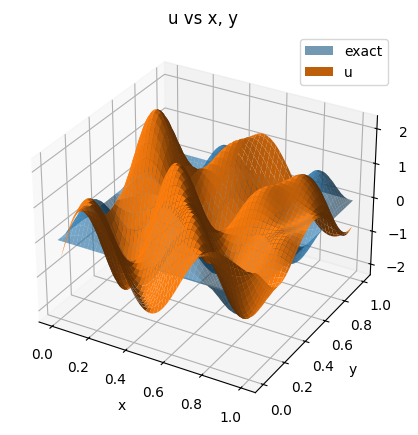

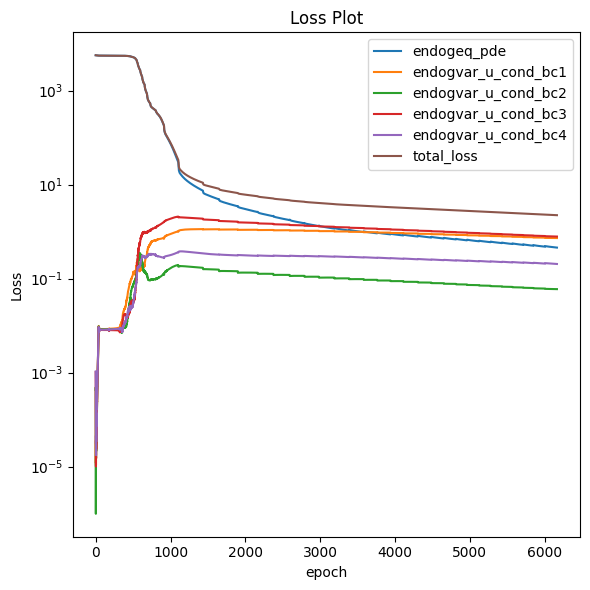

In [4]:
set_seeds(0)
pde = PDEModel("wave", {"optimizer_type": OptimizerType.Adam, "num_epochs": 10000, "sampling_method": SamplingMethod.FixedGrid, "batch_size": 20})
pde.set_state(["x", "y"], {"x": [0, 1], "y": [0, 1]})
pde.add_param("k", 4*torch.pi)
pde.add_endog("u", {"hidden_units": [150, 150, 150], "activation_type": ActivationType.SiLU})
pde.add_endog_equation("-u_xx-u_yy-k**2 * u = k**2 * sin(k*x) * sin(k*y)", label="pde")

zero_y = torch.zeros((100, 2))
zero_y[:, 0] = torch.linspace(0, 1, 100)
zero_x = torch.zeros((100, 2))
zero_x[:, 1] = torch.linspace(0, 1, 100)
one_y = torch.ones((100, 2))
one_y[:, 0] = torch.linspace(0, 1, 100)
one_x = torch.ones((100, 2))
one_x[:, 1] = torch.linspace(0, 1, 100)

pde.add_endog_condition("u", 
                        "u(SV)", {"SV": zero_y},
                        Comparator.EQ,
                        "0", {},
                        label="bc1")
pde.add_endog_condition("u", 
                        "u(SV)", {"SV": zero_x},
                        Comparator.EQ,
                        "0", {},
                        label="bc2")
pde.add_endog_condition("u", 
                        "u(SV)", {"SV": one_y},
                        Comparator.EQ,
                        "0", {},
                        label="bc3")
pde.add_endog_condition("u", 
                        "u(SV)", {"SV": one_x},
                        Comparator.EQ,
                        "0", {},
                        label="bc4")
print(pde)
if not os.path.exists("./models/helmholtz/model.pt"):
    pde.train_model("./models/helmholtz", "model.pt", True)
    pde.load_model(torch.load("./models/helmholtz/model_best.pt"))
    pde.eval_model(True)
else:
    pde.load_model(torch.load("./models/helmholtz/model_best.pt"))
    pde.eval_model(True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
x_np = np.linspace(0, 1, 100)
y_np = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_np, y_np)
exact_Z = np.sin(4*np.pi*X) * np.sin(4*np.pi*Y)
ax.plot_surface(X, Y, exact_Z, label="exact", alpha=0.6)
pde.endog_vars["u"].plot("u", {"x": [0., 1.], "y": [0, 1.]}, ax=ax)
plt.subplots_adjust()
plt.show()
plot_loss_df(fn="./models/helmholtz/model_min_loss.csv", loss_plot_fn="./models/helmholtz/model_min_loss.png")

=============================Summary of Model wave==============================
Config: {
 "batch_size": 20,
 "num_epochs": 10000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{
 "k": 12.566370614359172
}

================================State Variables=================================
x: [0, 1]
y: [0, 1]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: u
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=150, bias=True)
    (activation_0): Wavelet()
    (linear_1): Linear(in_features=150, out_features=150, bias=True)
    (activation_1): Wavelet()
    (linear_2): Linear(in_features=150, out_features=150, bias=True)
    (activa

Total loss: 0.8776: 100%|██████████| 10000/10000 [12:45<00:00, 13.07it/s]  


training finished, total time :: 765.1567974090576
Best model saved to ./models/helmholtz/model_wavelet_best.pt if valid
Model saved to ./models/helmholtz/model_wavelet.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_pde: 0.1338,
endogvar_u_cond_bc1: 0.0143,
endogvar_u_cond_bc2: 0.0074,
endogvar_u_cond_bc3: 0.0091,
endogvar_u_cond_bc4: 0.0081,
total_loss: 0.1728


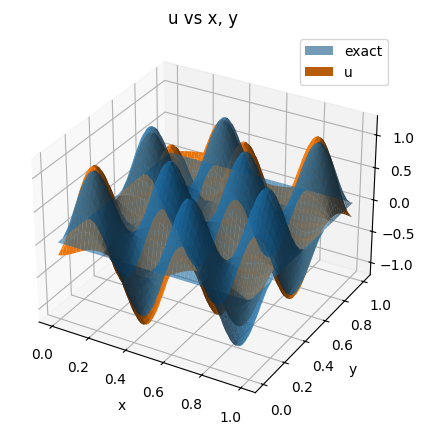

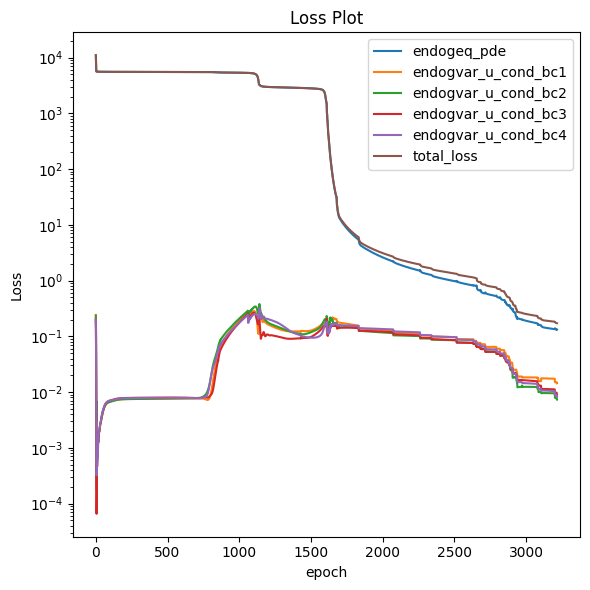

In [5]:
set_seeds(0)
pde = PDEModel("wave", {"optimizer_type": OptimizerType.Adam, "num_epochs": 10000, "sampling_method": SamplingMethod.FixedGrid, "batch_size": 20})
pde.set_state(["x", "y"], {"x": [0, 1], "y": [0, 1]})
pde.add_param("k", 4*torch.pi)
pde.add_endog("u", {"hidden_units": [150, 150, 150], "activation_type": ActivationType.Wavelet})
pde.add_endog_equation("-u_xx-u_yy-k**2 * u = k**2 * sin(k*x) * sin(k*y)", label="pde")

zero_y = torch.zeros((100, 2))
zero_y[:, 0] = torch.linspace(0, 1, 100)
zero_x = torch.zeros((100, 2))
zero_x[:, 1] = torch.linspace(0, 1, 100)
one_y = torch.ones((100, 2))
one_y[:, 0] = torch.linspace(0, 1, 100)
one_x = torch.ones((100, 2))
one_x[:, 1] = torch.linspace(0, 1, 100)

pde.add_endog_condition("u", 
                        "u(SV)", {"SV": zero_y},
                        Comparator.EQ,
                        "0", {},
                        label="bc1")
pde.add_endog_condition("u", 
                        "u(SV)", {"SV": zero_x},
                        Comparator.EQ,
                        "0", {},
                        label="bc2")
pde.add_endog_condition("u", 
                        "u(SV)", {"SV": one_y},
                        Comparator.EQ,
                        "0", {},
                        label="bc3")
pde.add_endog_condition("u", 
                        "u(SV)", {"SV": one_x},
                        Comparator.EQ,
                        "0", {},
                        label="bc4")
print(pde)
if not os.path.exists("./models/helmholtz/model_wavelet.pt"):
    pde.train_model("./models/helmholtz", "model_wavelet.pt", True)
    pde.load_model(torch.load("./models/helmholtz/model_wavelet_best.pt"))
    pde.eval_model(True)
else:
    pde.load_model(torch.load("./models/helmholtz/model_wavelet_best.pt"))
    pde.eval_model(True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
x_np = np.linspace(0, 1, 100)
y_np = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_np, y_np)
exact_Z = np.sin(4*np.pi*X) * np.sin(4*np.pi*Y)
ax.plot_surface(X, Y, exact_Z, label="exact", alpha=0.6)
pde.endog_vars["u"].plot("u", {"x": [0., 1.], "y": [0, 1.]}, ax=ax)
plt.subplots_adjust()
plt.show()
plot_loss_df(fn="./models/helmholtz/model_wavelet_min_loss.csv", loss_plot_fn="./models/helmholtz/model_wavelet_min_loss.png")